In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline

In [2]:
# options
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("../input/playground-series-s3e11/train.csv")
df_t = pd.read_csv("../input/playground-series-s3e11/test.csv")

In [4]:
df.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


In [5]:
df.shape

(360336, 17)

In [6]:
(df_t.shape[0]/(df.shape[0]+df_t.shape[0]))*100

40.0

In [7]:
df.nunique()

id                            360336
store_sales(in millions)        1044
unit_sales(in millions)            6
total_children                     6
num_children_at_home               6
avg_cars_at home(approx).1         5
gross_weight                     384
recyclable_package                 2
low_fat                            2
units_per_case                    36
store_sqft                        20
coffee_bar                         2
video_store                        2
salad_bar                          2
prepared_food                      2
florist                            2
cost                             328
dtype: int64

In [8]:
df.columns

Index(['id', 'store_sales(in millions)', 'unit_sales(in millions)',
       'total_children', 'num_children_at_home', 'avg_cars_at home(approx).1',
       'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case',
       'store_sqft', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food',
       'florist', 'cost'],
      dtype='object')

In [9]:
features = ['store_sales(in millions)', 'unit_sales(in millions)', 'total_children',
       'num_children_at_home', 'avg_cars_at home(approx).1', 'gross_weight',
       'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft',
       'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']
target = 'cost'

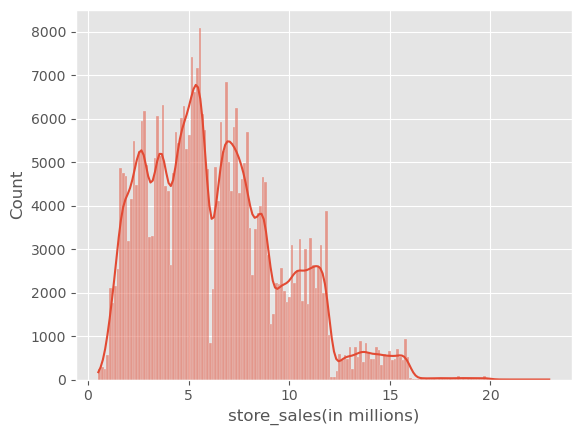

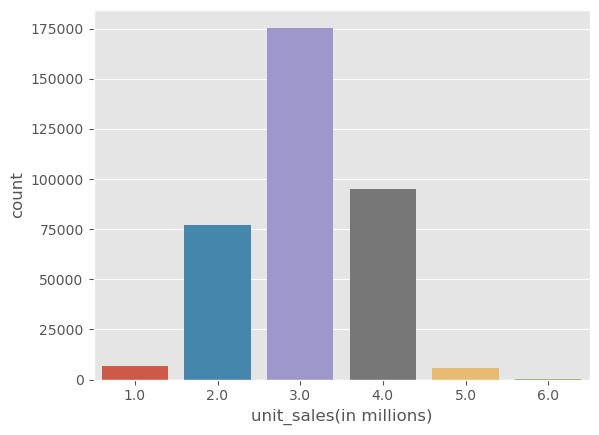

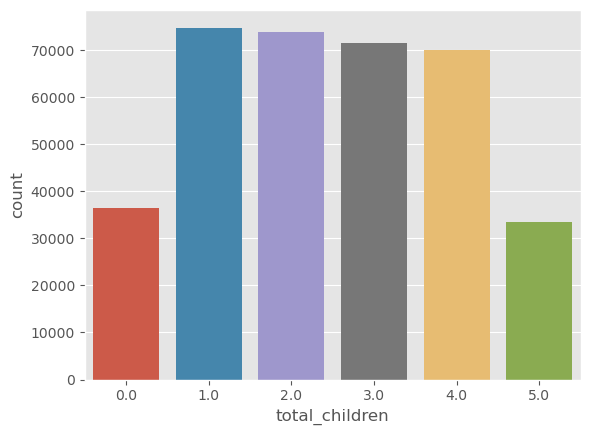

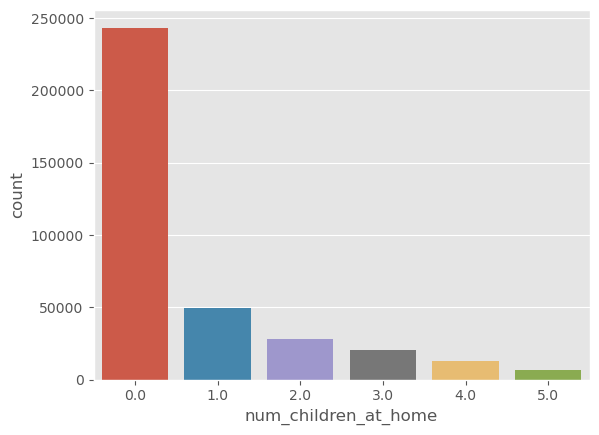

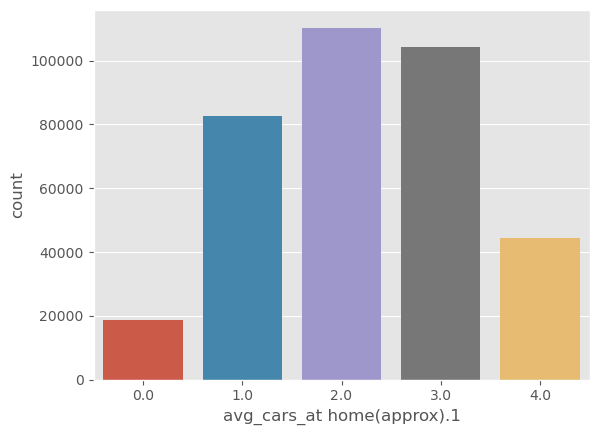

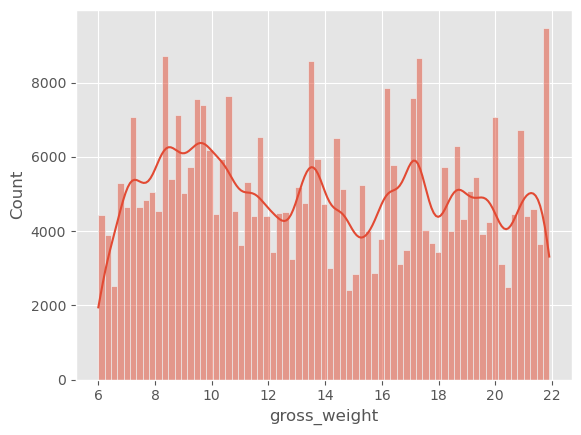

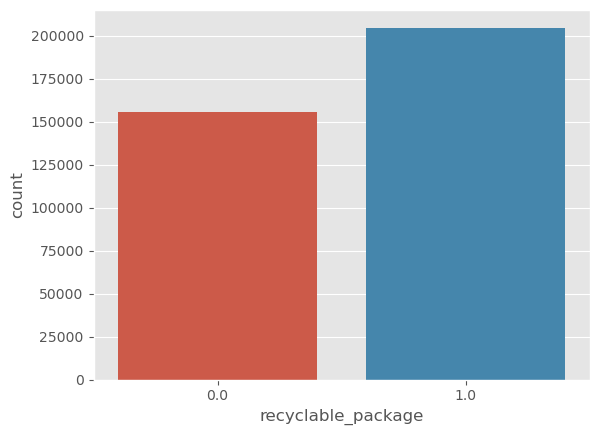

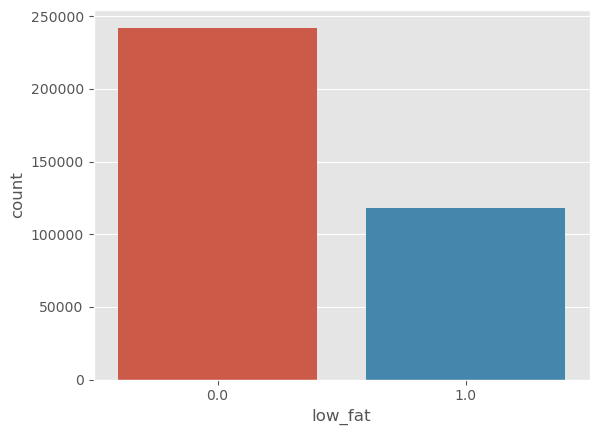

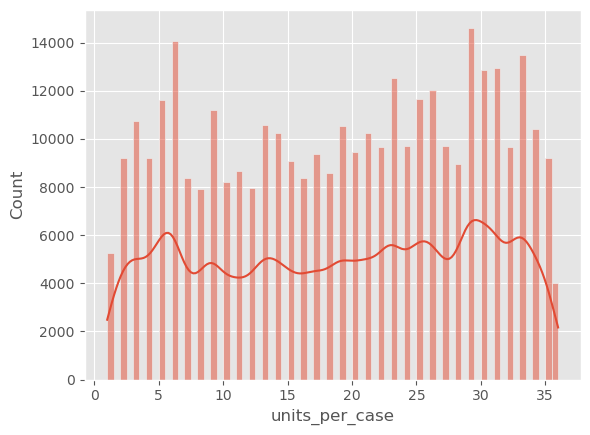

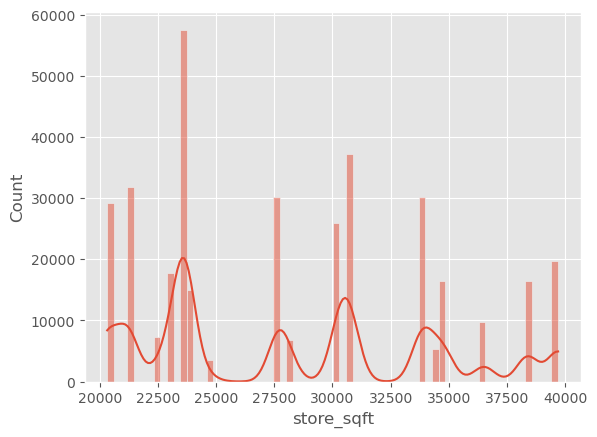

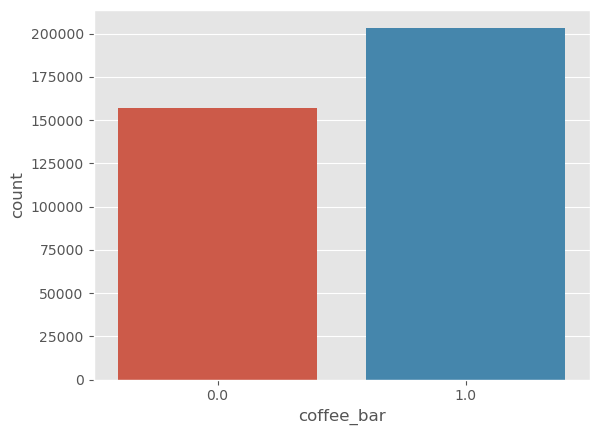

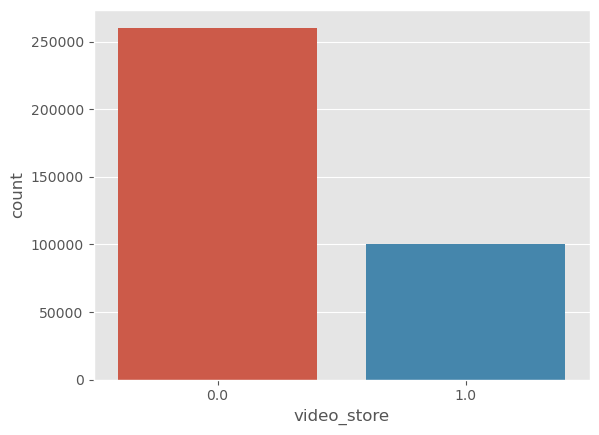

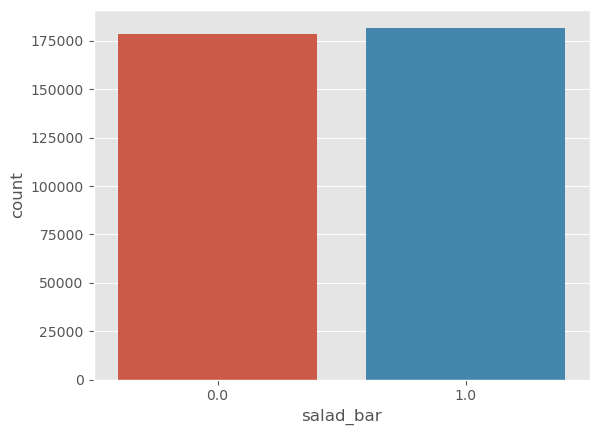

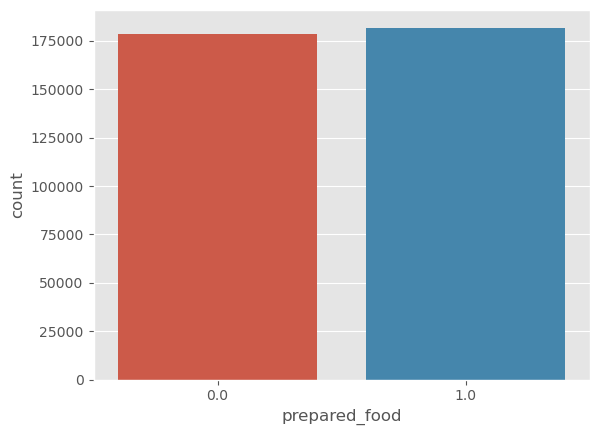

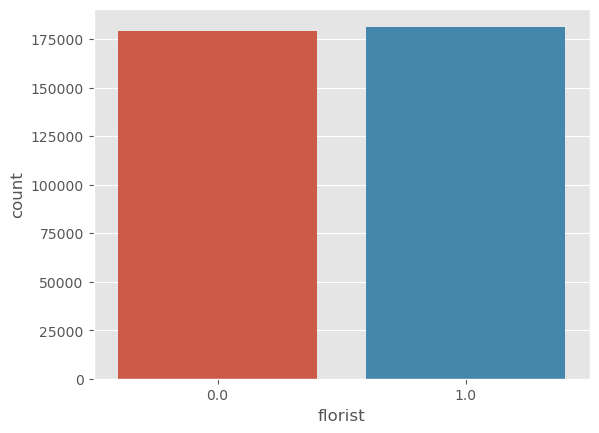

In [10]:
# bar plots and histplots to understand features and their distribution
for i, col in enumerate(features):
    if (df[col].nunique() > 6):
        plt.figure(i)
        sns.histplot(data=df, x=col, kde=True)
    else:
        plt.figure(i)
        sns.countplot(data=df, x=col)

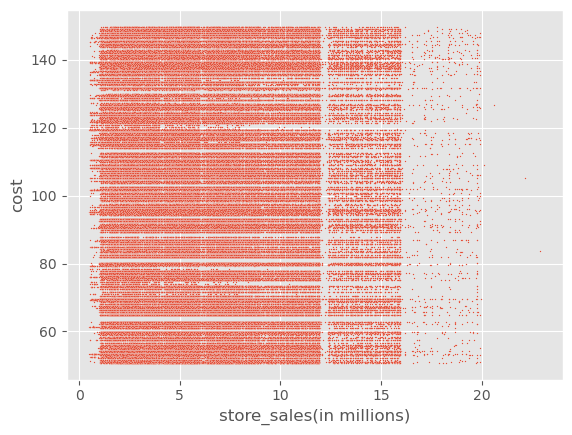

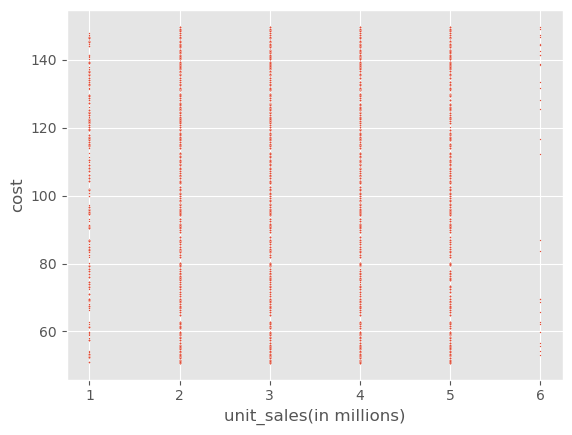

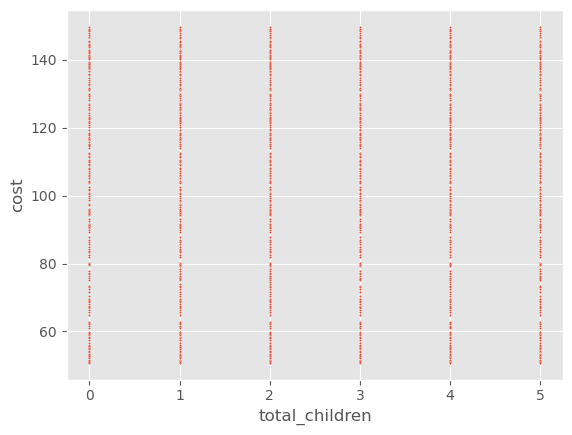

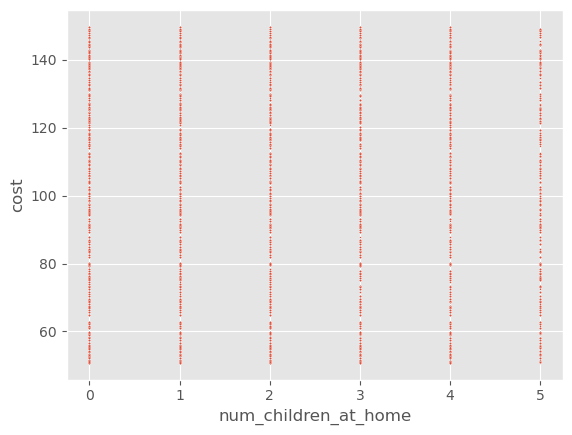

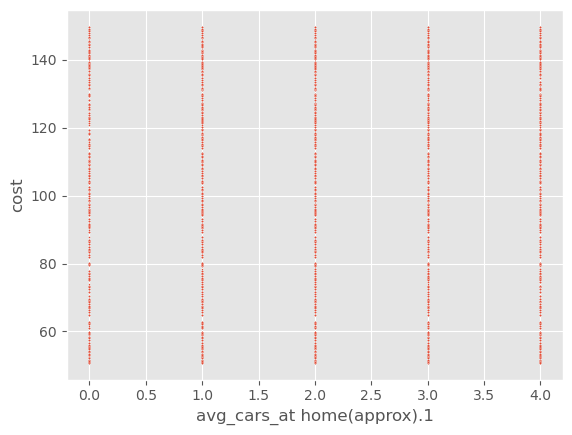

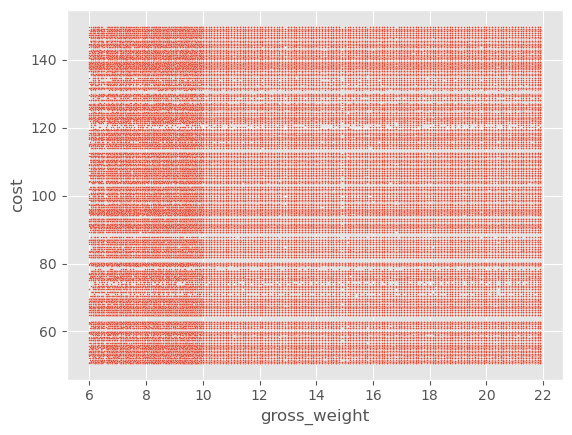

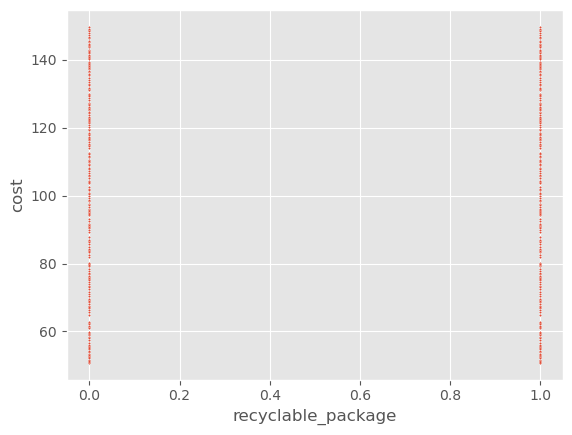

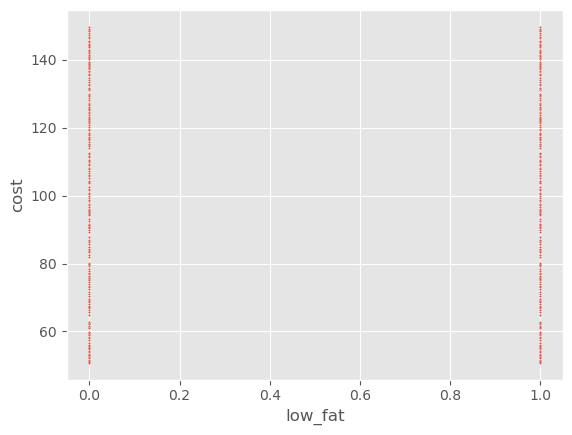

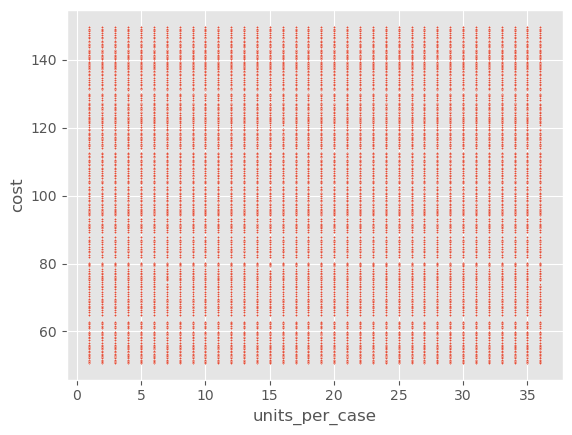

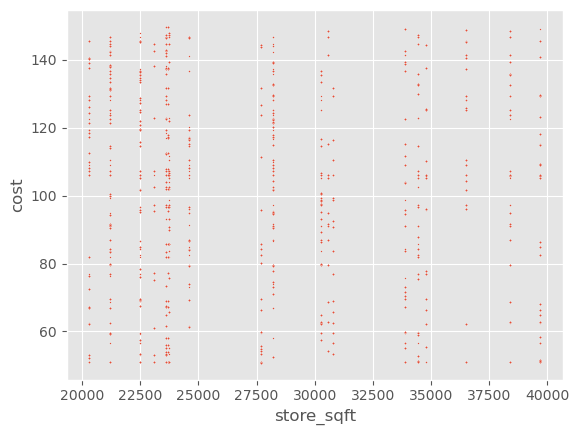

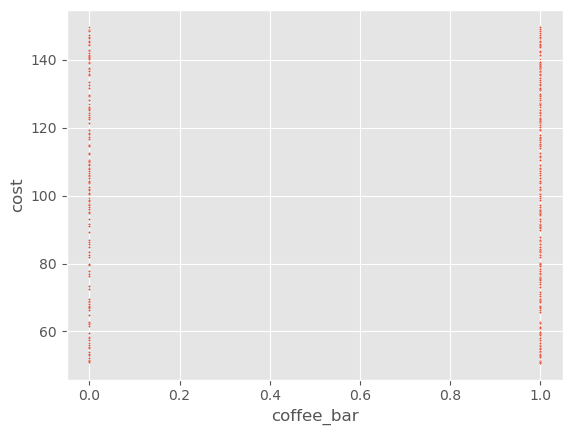

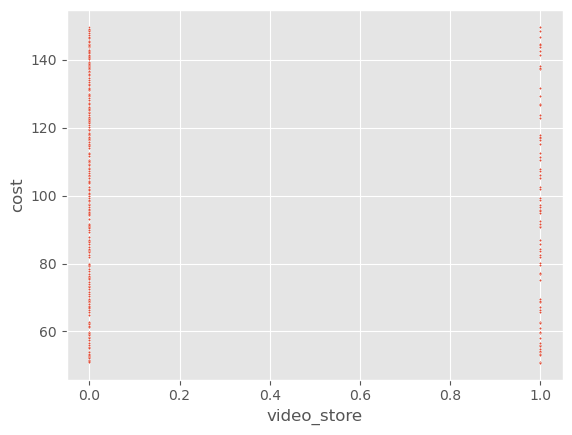

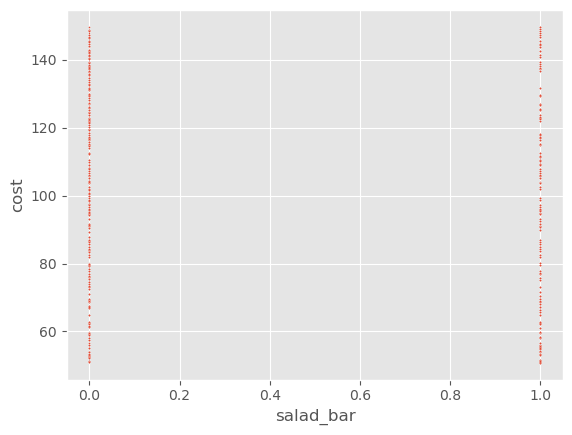

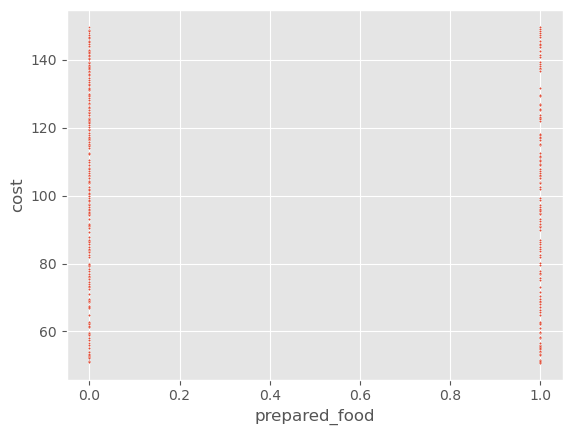

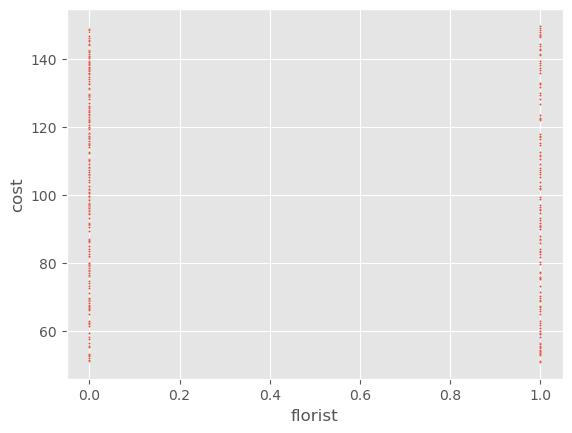

In [11]:
# sactter plots to understand features v. target
for i, col in enumerate(features):
    plt.figure(i)
    sns.scatterplot(data=df, x=col, y=target, s=1)

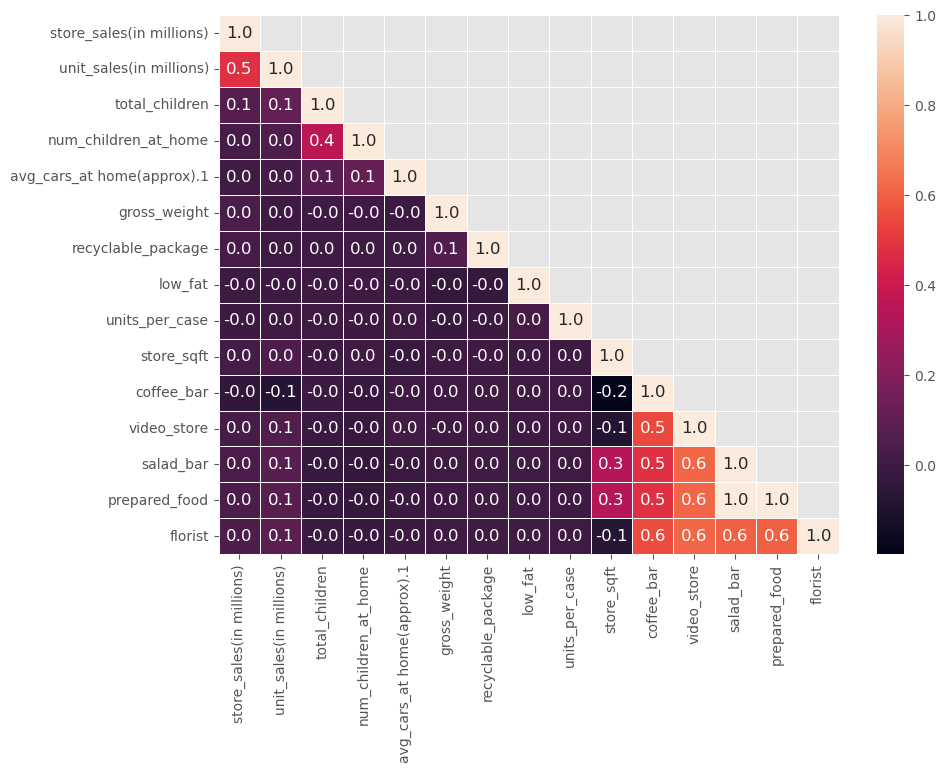

In [12]:
corr = df[features].corr(method='pearson')
triu = np.triu(corr)
np.fill_diagonal(triu, False)

plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt='.1f',annot_kws={"size":12}, linewidth=.6, mask=triu);

In [13]:
# creating a new feature
# since they're both highly correlated but still not the same
df["food_salad"] = df["prepared_food"] + df["salad_bar"]
df_t["food_salad"] = df_t["prepared_food"] + df_t["salad_bar"]
features.append("food_salad")

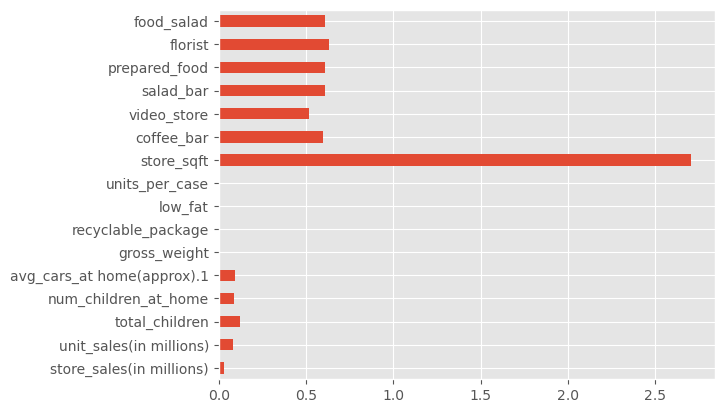

In [14]:
# feature importance
from sklearn.feature_selection import mutual_info_regression

importances = mutual_info_regression(df[features], df[target])
feat_importances = pd.Series(importances, features[0:len(features)])
feat_importances.plot(kind='barh')
plt.show()

# Conc: Doesn't affect score much but XGBR has some importance for all of them, so keeping all features in the training set

In [15]:
# Keeping original data
X_orig = df[features].copy()

In [16]:
from sklearn.preprocessing import RobustScaler
rscaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(11.0, 89.0), copy=True) # B2N 11% - 89%

# removed features and scaling
irr_features = ["prepared_food", "salad_bar"]
for f in irr_features:
    features.remove(f)

# scaling for feature removed dataframe
X = df[features].copy()
fs = []
for f in features:
    if (df[f].nunique() > 2):
        fs.append(f)

X[fs] = rscaler.fit_transform(df[fs])

# preparing test data
X_test = df_t[features].copy()
X_test[fs] = rscaler.fit_transform(df_t[fs])

# target variable
y = df[target]

In [17]:
# checking if shapes are same
X.shape, X_test.shape

((360336, 14), (240224, 14))

In [18]:
X

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,florist,food_salad
0,0.336504,0.0,0.000000,1.0,0.000000,-0.270714,1.0,0.0,0.444444,0.576370,0.0,0.0,0.0,-1.0
1,-0.092747,-0.5,0.666667,0.0,0.333333,-0.569319,1.0,0.0,-0.703704,0.033477,1.0,0.0,0.0,-1.0
2,0.986920,0.5,-0.666667,0.0,0.333333,0.631665,1.0,0.0,0.222222,-0.423630,1.0,0.0,0.0,-1.0
3,-0.209275,0.0,1.000000,0.0,-0.666667,0.098441,0.0,1.0,0.592593,-0.423630,1.0,0.0,0.0,-1.0
4,-0.434007,0.0,1.000000,0.0,0.333333,0.278917,1.0,1.0,0.000000,0.000000,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360331,0.216409,0.5,1.000000,2.5,0.333333,-0.008203,1.0,0.0,0.481481,0.168301,0.0,0.0,0.0,-1.0
360332,1.029727,0.5,0.666667,0.0,0.666667,0.426579,1.0,1.0,-0.074074,-0.482215,0.0,0.0,0.0,-1.0
360333,0.589774,0.0,-0.666667,0.0,0.000000,-0.188679,1.0,0.0,0.555556,0.188963,1.0,1.0,1.0,0.0
360334,0.625446,0.0,-0.333333,0.0,0.333333,-0.278917,0.0,1.0,-0.222222,0.188963,1.0,1.0,1.0,0.0


In [19]:
X_test

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,florist,food_salad
0,0.171429,0.5,-0.333333,0.0,0.000000,-0.229508,0.0,1.0,-0.481481,-0.482215,0.0,0.0,0.0,-1.0
1,0.130952,-0.5,0.000000,1.0,0.333333,-0.417213,1.0,0.0,-0.592593,0.403034,1.0,0.0,1.0,0.0
2,0.302381,0.0,-0.666667,0.0,0.333333,-0.395902,0.0,1.0,-0.222222,0.784752,0.0,0.0,0.0,0.0
3,-0.038095,-0.5,0.333333,1.5,0.000000,0.680328,1.0,0.0,-0.407407,-0.261933,1.0,1.0,1.0,0.0
4,-0.119048,0.0,0.000000,0.0,0.000000,-0.221311,1.0,0.0,-0.333333,0.000000,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240219,0.333333,0.5,-0.666667,0.0,-0.333333,-0.427049,0.0,0.0,-0.148148,0.698836,0.0,0.0,0.0,-1.0
240220,-0.178571,-0.5,0.000000,0.0,0.666667,-0.468852,1.0,0.0,-0.592593,0.168301,0.0,0.0,0.0,-1.0
240221,0.059524,0.0,-0.666667,0.0,0.333333,-0.172131,0.0,0.0,-0.259259,0.784752,0.0,0.0,0.0,0.0
240222,0.254762,-0.5,-0.666667,0.0,0.000000,-0.431967,1.0,0.0,-0.444444,-0.257290,1.0,0.0,1.0,0.0


In [20]:
# cross-validation
from sklearn import model_selection

n_splits=5
fold=1

kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=17)

for train_idx, test_idx in kf.split(X, y):
    print(f'Fold {fold}: Train: {len(train_idx)}; Test:{len(test_idx)}')
    fold+=1

Fold 1: Train: 288268; Test:72068
Fold 2: Train: 288269; Test:72067
Fold 3: Train: 288269; Test:72067
Fold 4: Train: 288269; Test:72067
Fold 5: Train: 288269; Test:72067


In [21]:
# model selection
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge

Original score: 0.3032
S/R Score : 0.3031


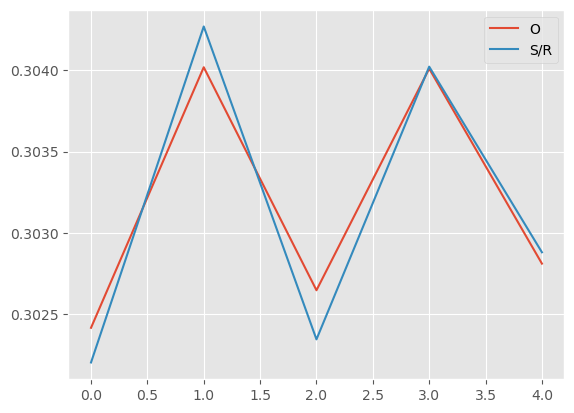

In [22]:
score_orig = model_selection.cross_val_score(LGBMRegressor(random_state=17), X_orig, y, cv=kf, scoring="neg_mean_squared_log_error")
score = model_selection.cross_val_score(LGBMRegressor(random_state=17), X, y, cv=kf, scoring="neg_mean_squared_log_error")

# print(f'Scores for each fold are: {np.sqrt(abs(score_orig))}')
print(f'Original score: {"{:.4f}".format(np.sqrt(abs(score_orig)).mean())}')
# print(f'Scores for each fold are: {np.sqrt(abs(score))}')
print(f'S/R Score : {"{:.4f}".format(np.sqrt(abs(score)).mean())}')

plt.plot(np.sqrt(abs(score_orig)), label='O')
plt.plot(np.sqrt(abs(score)), label='S/R')
plt.legend()

Original score: 0.3023
S/R Score : 0.3023


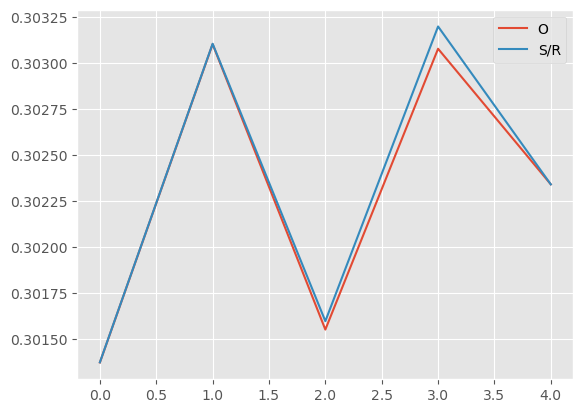

In [23]:
score_orig = model_selection.cross_val_score(XGBRegressor(random_state=17), X_orig, y, cv=kf, scoring="neg_mean_squared_log_error")
score = model_selection.cross_val_score(XGBRegressor(random_state=17), X, y, cv=kf, scoring="neg_mean_squared_log_error")

# print(f'Scores for each fold are: {np.sqrt(abs(score_orig))}')
print(f'Original score: {"{:.4f}".format(np.sqrt(abs(score_orig)).mean())}')
# print(f'Scores for each fold are: {np.sqrt(abs(score))}')
print(f'S/R Score : {"{:.4f}".format(np.sqrt(abs(score)).mean())}')

plt.plot(np.sqrt(abs(score_orig)), label='O')
plt.plot(np.sqrt(abs(score)), label='S/R')
plt.legend()

Original score: 0.3021
S/R Score : 0.3020


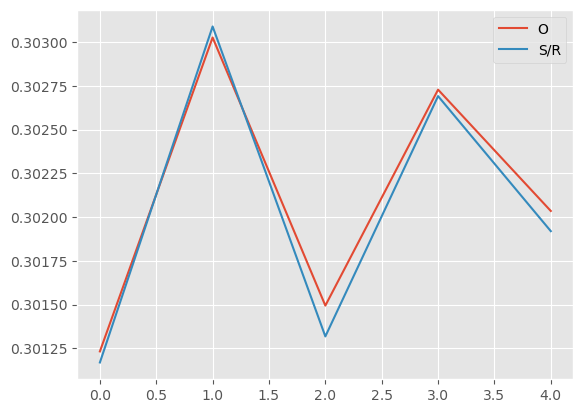

In [24]:
score_orig = model_selection.cross_val_score(CatBoostRegressor(random_state=17, verbose=False), X_orig, y, cv=kf, scoring="neg_mean_squared_log_error")
score = model_selection.cross_val_score(CatBoostRegressor(random_state=17, verbose=False), X, y, cv=kf, scoring="neg_mean_squared_log_error")

# print(f'Scores for each fold are: {np.sqrt(abs(score_orig))}')
print(f'Original score: {"{:.4f}".format(np.sqrt(abs(score_orig)).mean())}')
# print(f'Scores for each fold are: {np.sqrt(abs(score))}')
print(f'S/R Score : {"{:.4f}".format(np.sqrt(abs(score)).mean())}')

plt.plot(np.sqrt(abs(score_orig)), label='O')
plt.plot(np.sqrt(abs(score)), label='S/R')
plt.legend()

Original score: 0.3184
S/R Score : 0.3190


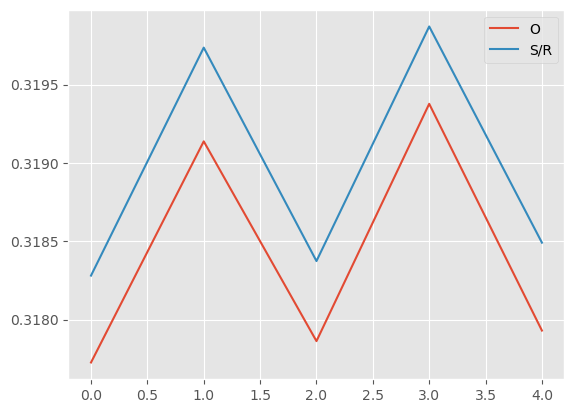

In [25]:
score_orig = model_selection.cross_val_score(ElasticNet(random_state=17), X_orig, y, cv=kf, scoring="neg_mean_squared_log_error")
score = model_selection.cross_val_score(ElasticNet(random_state=17), X, y, cv=kf, scoring="neg_mean_squared_log_error")

# print(f'Scores for each fold are: {np.sqrt(abs(score_orig))}')
print(f'Original score: {"{:.4f}".format(np.sqrt(abs(score_orig)).mean())}')
# print(f'Scores for each fold are: {np.sqrt(abs(score))}')
print(f'S/R Score : {"{:.4f}".format(np.sqrt(abs(score)).mean())}')

plt.plot(np.sqrt(abs(score_orig)), label='O')
plt.plot(np.sqrt(abs(score)), label='S/R')
plt.legend()

Original score: 0.3169
S/R Score : 0.3169


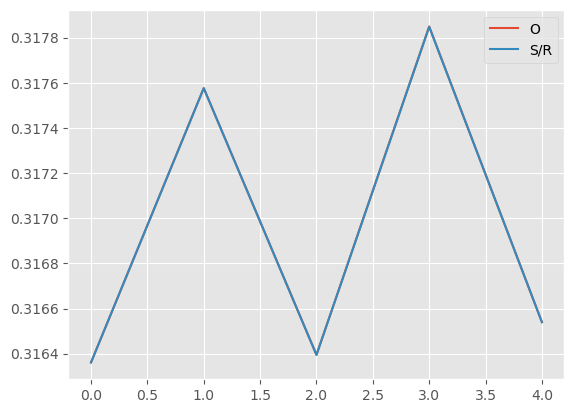

In [26]:
score_orig = model_selection.cross_val_score(BayesianRidge(), X_orig, y, cv=kf, scoring="neg_mean_squared_log_error")
score = model_selection.cross_val_score(BayesianRidge(), X, y, cv=kf, scoring="neg_mean_squared_log_error")

# print(f'Scores for each fold are: {np.sqrt(abs(score_orig))}')
print(f'Original score: {"{:.4f}".format(np.sqrt(abs(score_orig)).mean())}')
# print(f'Scores for each fold are: {np.sqrt(abs(score))}')
print(f'S/R Score : {"{:.4f}".format(np.sqrt(abs(score)).mean())}')

plt.plot(np.sqrt(abs(score_orig)), label='O')
plt.plot(np.sqrt(abs(score)), label='S/R')
plt.legend()

In [27]:
X.shape, y.shape

((360336, 14), (360336,))

In [28]:
# Hyperparameter tuning using hyperopt
from sklearn import metrics
from functools import partial
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope


# optimizer function to find msles. We need to find the sqrt(msle) and minimize it.
def optimize(params, X, y):
    model = XGBRegressor(**params, num_parallel_tree=3, grow_policy='lossguide', max_bin=1024, tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')
    kf = model_selection.KFold(n_splits=5)
    msles = []
    for idx in kf.split(X=X, y=y):
        train_idx, valid_idx = idx[0], idx[1]
        xtrain, xvalid = X.iloc[train_idx], X.iloc[valid_idx]
        ytrain, yvalid = y.iloc[train_idx], y.iloc[valid_idx]
        model.fit(xtrain, ytrain)
        preds = model.predict(xvalid)
        fold_acc = metrics.mean_squared_log_error(yvalid, preds)
        msles.append(fold_acc)
    
    return np.mean(np.sqrt(msles))

In [29]:
# parameter space for XGBoost Regressor
param_space = {
    "eta": hp.uniform("eta", 0.01, 0.1),
    "gamma": hp.uniform("gamma", 0.05, 1.0),
    "max_depth": hp.choice("max_depth", range(3, 15)),
    "min_child_weight": hp.quniform("min_child_weight", 2, 7, 1),
    "subsample": hp.uniform("subsample", 0.5, 0.9),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 0.9),
    "lambda": hp.loguniform("lambda", 0.01, 2),
    "alpha": hp.loguniform("alpha", 0.01, 5)
}

In [30]:
# using scaled data to our optimization function
optimization_function = partial(optimize, X=X, y=y)

In [31]:
# n trials
trials = Trials()

result = fmin(
    fn=optimization_function,
    space=param_space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials)

100%|██████████| 30/30 [42:33<00:00, 85.12s/trial, best loss: 0.2982839711697812]


In [32]:
print(result)
params = result

{'alpha': 3.823171926273806, 'colsample_bytree': 0.7841063345430093, 'eta': 0.04051004711607928, 'gamma': 0.7258864677933267, 'lambda': 1.2738202979755984, 'max_depth': 10, 'min_child_weight': 2.0, 'subsample': 0.8086523535787818}


In [33]:
xgbr = XGBRegressor(num_parallel_tree=3, grow_policy='lossguide', max_bin=1024, tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')
xgbr.set_params(**params)
xgbr.fit(X, y)

XGBRegressor(alpha=3.823171926273806, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7841063345430093, early_stopping_rounds=None,
             enable_categorical=False, eta=0.04051004711607928,
             eval_metric=None, gamma=0.7258864677933267, gpu_id=0,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints='', lambda=1.2738202979755984,
             learning_rate=0.0405100472, max_bin=1024, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=2.0,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=3, predictor='gpu_predictor', ...)

In [34]:
preds = xgbr.predict(X_test)

In [35]:
submission = pd.DataFrame({'id': df_t.id, 'cost': preds})

In [36]:
submission

,id,cost
0,360336,100.248688
1,360337,95.638535
2,360338,94.714355
3,360339,98.329453
4,360340,82.382393
...,...,...
240219,600555,101.102493
240220,600556,93.977051
240221,600557,96.854858
240222,600558,109.003616


In [37]:
submission.to_csv('submission_xgbr_final.csv', index=False)